In [1]:
import os
from io import BytesIO
import subprocess
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from Bio.SeqUtils import GC

In [2]:
def cal_gc(seqfile):
    seq = ''
    with open(seqfile) as handle:
        for line in handle:
            if line.startswith('>') is False:
                seq += line.strip()
    return GC(seq)

In [3]:
exe = '/home/chen1i6c04/Tools/seqkit'

def stats(patterm):
    cmd = f'{exe} stats -a -T -j 16 {patterm}'
    child_process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True)
    stdout, stderr = child_process.communicate()
    return pd.read_csv(BytesIO(stdout), sep='\t')

In [4]:
dirpath = '/media/NGS/Sequence/Shigella_dysenteriae/NCBI'

In [5]:
statistics = stats(os.path.join(dirpath, '*'))
statistics.index = statistics['file'].apply(lambda x: os.path.splitext(os.path.basename(x))[0]).to_list()
statistics['GC%'] = [cal_gc(file) for file in statistics['file']]
statistics['Size(MB)'] = statistics['sum_len']/1000000

In [6]:
statistics.to_csv('/media/NGS/Sequence/Shigella_dysenteriae/statistics.txt', sep='\t', index=0)

In [8]:
identify = pd.read_csv('/media/NGS/Sequence/Shigella_dysenteriae/Identify.csv', index_col=0)

In [99]:
table = pd.concat([identify, statistics], axis=1, join='inner')
table = table[(table['Species'] == 'Shigella dysenteriae')&(table['Query_Coverage']>=50)&(table['Template_Coverage']>=50)]
table.shape

(607, 36)

# N50

In [85]:
log_data = np.log10(table["N50"])
start = np.floor(log_data).min()
stop = np.ceil(log_data).max()
bins = np.arange(start, stop, 0.01)
hist, bin_edges = np.histogram(log_data, bins=bins)
threshold = max(tuple(zip(hist, bin_edges)), key=lambda x: x[0])[1]
threshold

4.269999999999994

In [86]:
curated = table[(table['N50'] >= 10 ** threshold)]
curated.shape

(344, 36)

# Combine metadata selection

In [87]:
def fn(s):
    std = s.std()
    mean = s.mean()
    return (s > (mean - 2*std))&(s<(mean + 2*std))

/home/chen1i6c04/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/chen1i6c04/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


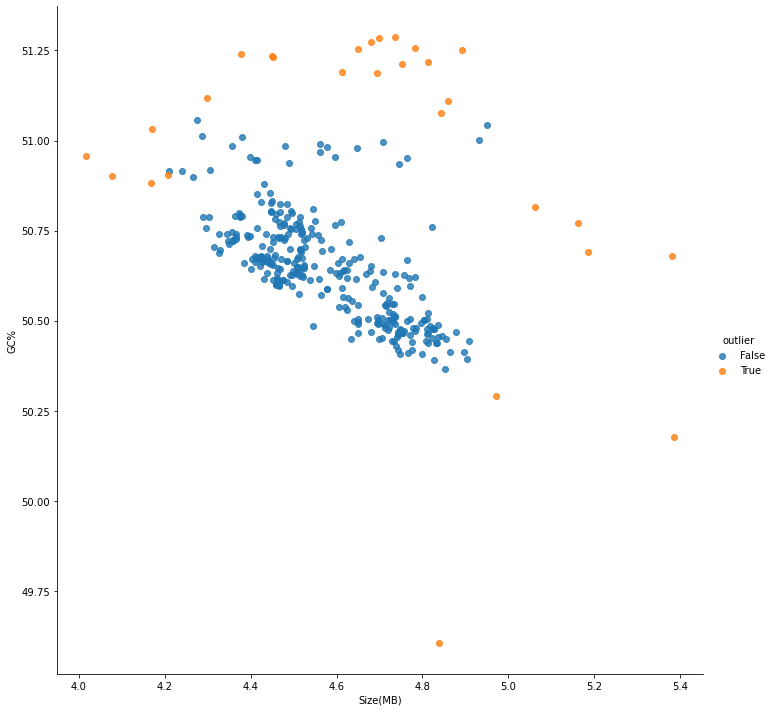

In [88]:
curated.loc[:, 'outlier'] = ~(fn(curated['GC%'])&fn(curated['Size(MB)']))
sns.lmplot(data=curated, x="Size(MB)", y="GC%", fit_reg=False, height=10, hue='outlier')

In [89]:
curated = curated[~curated['outlier']]
curated.shape

(316, 37)

# Counts

Text(0.5, 1.0, 'Genome contig number distribution')

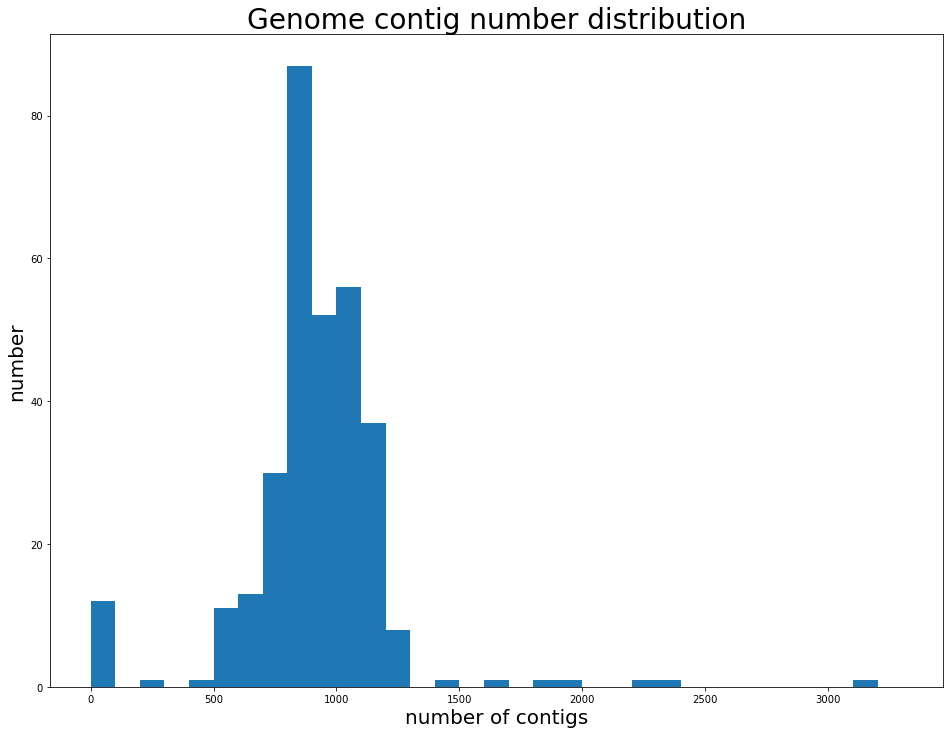

In [97]:
bins = range(0, curated["num_seqs"].max(), 100)

fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.hist(curated["num_seqs"], bins=bins, cumulative=False)
plt.xlabel("number of contigs", fontsize=20)
plt.ylabel("number", fontsize=20)
plt.title("Genome contig number distribution", fontsize=28)

In [98]:
for file in curated['file']:
    shutil.copy(file, '/media/NGS/Sequence/Shigella_dysenteriae/NCBI_clean')